# Chapter 9 - Support Vector Machines

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.datasets import make_blobs
plt.style.use('seaborn-white')

## 8) This problem involves the OJ data set which is part of the ISLR package.

In [2]:
data=pd.read_csv('../Data/OJ.csv')
data.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [3]:
#Convert string data to be coded as integers
data.Purchase=pd.Categorical(data.Purchase)
data.Purchase=data.Purchase.cat.codes
data.Store7=pd.Categorical(data.Store7)
data.Store7=data.Store7.cat.codes
data.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,0,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0,0.000000,0.000000,0.24,1
1,0,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0,0.150754,0.000000,0.24,1
2,0,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0,0.000000,0.091398,0.23,1
3,1,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0,0.000000,0.000000,0.00,1
4,0,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,1,0.000000,0.000000,0.00,0


#### (a) Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [4]:
Y = data.Purchase
X = data.loc[:, data.columns != 'Purchase']
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=800, random_state=1)

#### (b) Fit a support vector classifier to the training data using cost=0.01, with Purchase as the response and the other variables as predictors. Use the summary() function to produce summary statistics, and describe the results obtained.

(*Purchase* is a factor with levels CH and MM indicating whether the customer purchased Citrus Hill or Minute Maid Orange Juice)

In [5]:
svc = SVC(C=0.01, kernel='linear',random_state=1).fit(X_train, y_train)
y_predicted = svc.predict(X_test)
y_true = y_test
print(classification_report(y_true, y_predicted, target_names=['CH', 'MM']))

              precision    recall  f1-score   support

          CH       0.62      0.96      0.76       157
          MM       0.77      0.20      0.32       113

    accuracy                           0.64       270
   macro avg       0.70      0.58      0.54       270
weighted avg       0.68      0.64      0.57       270



The reports produces classification metrics on a per-class basis, as well as averages for the total model. 

**Precision**: Precision is the ability of a classifier not to label an instance positive that is actually negative. It is the accuracy of positive predictions, ie. the fraction of positive predictions that are actually positive.

**Recall**: Recall is the ability of a classifier to find all positive instances, i.e. the fraction of positives that were correctly identified.

**F1 Score**: It is the Harmonic Mean between precision and recall, a good metric to evaluate the overall performance of the model if we don't care specifically about maximizing either precision or recall.

**Support**: Number of occurences of the class.

Overall, the model has bad performance which we can see from the average f1 score.
However, we can see that it is mainly the class MM's recall that it is struggling with. The recall for MM is low, meaning that many MM observations were incorrectly classified as CH. At the same time, recall for CH is high meaning that most CH observations were correctly classified as CH.

#### (c) What are the training and test error rates
The test error rate can also be seen in the classification report above. **Accuracy** is the same as the error rate since it is the proportion of correct classifications. In this case it is 64%. This is only a good metric to use when the dataset is more or less balanced. Let's compute the training error: 

In [6]:
print("Training error: "+str(svc.score(X_train,y_train)))

Training error: 0.69


As we can see the training error is a decent amount better than the test error.

#### (d) Use the tune() function to select an optimal cost. Consider values in the range 0.01 to 10.


I will use 5-fold cross validation using gridSearchCV to choose an optimal value of C. For some reason, the gridSearch never manages to finish if I choose a value >= 9.0, which is why I try values between 0.01 and 8.9 instead.

In [7]:
param_grid = {
    'C': np.linspace(0.01, 8.9,num=20), #20 different C's between 0.01 and 10
    'kernel':['linear'] #We only try linear kernel
}
svc_best = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv = 5, n_jobs = -1)
svc_best.fit(X_train, y_train)
print("Best parameters: ")
svc_best.best_params_

Best parameters: 


{'C': 2.349473684210526, 'kernel': 'linear'}

#### (e) Compute the training and test error rates using this new value for cost.


In [8]:
print("Training error: "+str(svc_best.score(X_train,y_train)))
print("Test error: "+str(svc_best.score(X_test,y_test)))

Training error: 0.8375
Test error: 0.825925925925926


This time using the tuned C parameter we obtain a much better training and test error!

#### (f) Repeat parts (b) through (e) using a support vector machine with a radial kernel. Use the default value for gamma.

In [9]:
svc_radial = SVC(C=0.01, kernel='rbf',random_state=1).fit(X_train, y_train)
y_predicted = svc_radial.predict(X_test)
y_true = y_test
print(classification_report(y_true, y_predicted, target_names=['CH', 'MM'],zero_division=0))

              precision    recall  f1-score   support

          CH       0.58      1.00      0.74       157
          MM       0.00      0.00      0.00       113

    accuracy                           0.58       270
   macro avg       0.29      0.50      0.37       270
weighted avg       0.34      0.58      0.43       270



With the radial kernel, cost 0.01 and default gamma, the classifier always predicts CH which is useless, even though that means it recieves an accuracy of 58%. Let's see if we can improve that with other gamma-values.

In [10]:
param_grid = {
    'C': np.linspace(0.01, 8.9,num=20), #20 different C's between 0.01 and 8.9
    'gamma': np.linspace(0.0001,5,num=10),#10 different gammas 
    'kernel':['rbf'] #We only use radial kernel
}
svc_rad_best = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv = 5, n_jobs = -1)
svc_rad_best.fit(X_train, y_train)
print("Best parameters: ")
svc_rad_best.best_params_

Best parameters: 


{'C': 8.9, 'gamma': 0.5556444444444445, 'kernel': 'rbf'}

In [11]:
print("Training error: "+str(svc_rad_best.score(X_train,y_train)))
print("Test error: "+str(svc_rad_best.score(X_test,y_test)))

Training error: 0.8925
Test error: 0.7444444444444445


Interesting enough, we get a high training score but the test error is worse than in the linear case. This is either a matter of overfitting or underfitting, but it is not clear which one. Having a good training error with a significantly lower test score typically means that the model is overfit, having a high variance. But, as we can see the model that scored the highest uses a C of 8.9, which is the highest smoothing parameter we supplied. This indicates that the model might actually suffer from a high bias. I am not completely sure how to test what the problem is. I think it is possible to plot the test and the train error as funtions of the training set size, and evaluate that graph. However I will not do that now. Instead I will evaluate the polynomial kernel.

#### (g) Repeat parts (b) through (e) using a support vector machine with a polynomial kernel. Set degree=2.

In Scikit-learn the polynomial kernel is defined as $(\gamma \langle x, x'\rangle + r)^d$ where $r$ is specified by the keyword coef0. To use the same kernel as specified in the book we therefore set $\gamma = r = 1$

In [14]:
svc_pol = SVC(C=0.01, kernel='poly',coef0=1.0,gamma=1.0,degree=2,random_state=1).fit(X_train, y_train)
y_predicted = svc_pol.predict(X_test)
y_true = y_test
print(classification_report(y_true, y_predicted, target_names=['CH', 'MM']))

              precision    recall  f1-score   support

          CH       0.83      0.88      0.85       157
          MM       0.82      0.74      0.78       113

    accuracy                           0.82       270
   macro avg       0.82      0.81      0.81       270
weighted avg       0.82      0.82      0.82       270



The 2nd degree polynomial kernel when simply using C=0.01 performs as good as the best other one we found! Let's try tuning it with C

In [16]:
param_grid = {
    'C': np.linspace(0.01, 8.9,num=20), #20 different C's between 0.01 and 10.0
    'kernel':['poly'], #We only try polynomial kernel
    'degree':[2],
    'coef0':[1.0]
}
svc_pol_best = GridSearchCV(estimator = SVC(coef0=1.0, degree=2), param_grid = param_grid, cv = 5, n_jobs = -1)
svc_pol_best.fit(X_train, y_train)
print("Best parameters: "+str(svc_pol_best.best_params_))
print()

print("Training error: "+str(svc_pol_best.score(X_train,y_train)))
print("Test error: "+str(svc_pol_best.score(X_test,y_test)))

Best parameters: {'C': 0.01, 'coef0': 1.0, 'degree': 2, 'kernel': 'poly'}

Training error: 0.62
Test error: 0.5814814814814815


For some very weird reason, the gridsearch model does a worse job than the first model. I never managed ton figure out what went wrong. Instead, I decided to continue exploring SVMs.

#### (h) Overall, which approach seems to give the best results on this data?

It seems as the specific polynomial kernel which was tried performed the best, but for some reason the gridsearch was giving a worse model even when using the same paramters, so it is not clear which model in reality is the best since there seems to be some kind of bug. Instead, I decided to go on and try visualizing SVMs by using a two-dimensional simulated dataset with clear class boundaries.

## SVM on 2D data

In [20]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

df = pd.DataFrame(X,columns=['x','y'])
df['Class'] = y

X=df.loc[:,['x','y']]
y=df.Class

df

,x,y,Class
0,-2.385199,0.026417,0
1,-1.748303,-1.422691,0
2,-2.454317,-1.460714,0
3,1.874387,-0.160399,2
4,-0.485640,2.815078,1
...,...,...,...
995,3.337993,-2.637151,2
996,-0.725731,3.636355,1
997,-1.886913,-1.675268,0
998,-0.967147,4.629651,1


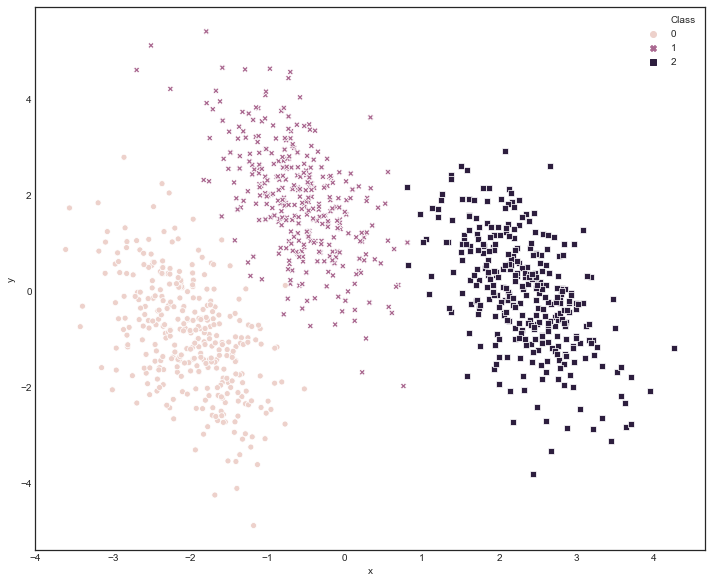

In [22]:
#Visualize distribution
fig = plt.figure(figsize = (12,10))
ax = sns.scatterplot(x="x", y="y",style='Class',hue="Class", data=df)

#Split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class',axis=1), y, train_size=0.33, random_state=1)

In [23]:
### Linear kernel

param_grid = {
    'C': np.linspace(0.001, 10,num=30), #30 different C's between 0.01 and 10
    'kernel':['linear'], #We only try linear kernel
}
svc_linear = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv = 5, n_jobs = -1)
svc_linear.fit(X_train, y_train)
               
print("Best parameters: "+str(svc_linear.best_params_))
               
y_predicted = svc_linear.predict(X_test)
y_true = y_test

Best parameters: {'C': 5.172896551724139, 'kernel': 'linear'}


### Decision boundary

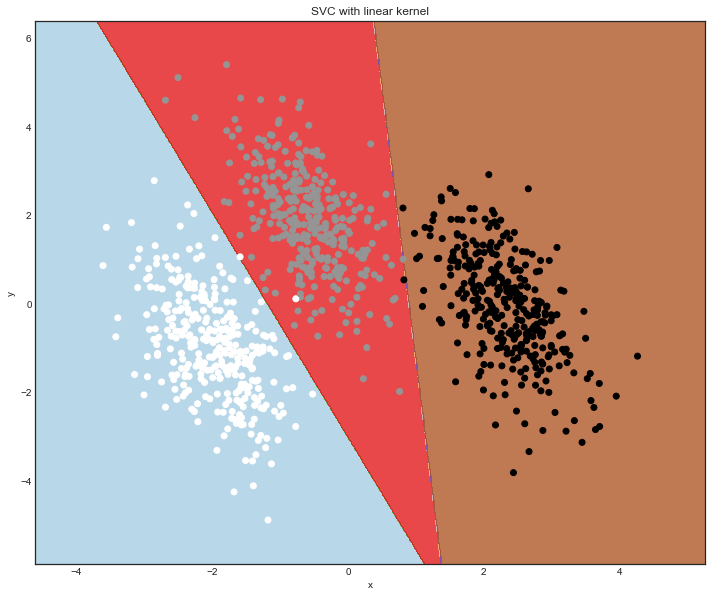

In [24]:
# create a mesh to plot in
x_min, x_max = df.x.min() - 1, df.x.max() + 1
y_min, y_max = df.y.min() - 1, df.y.max() + 1
h = abs((x_max / x_min)/100)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
x=np.c_[xx.ravel(), yy.ravel()]
Z = svc_linear.predict(x)
                       
#Decision boundary plot
fig = plt.figure(figsize = (12,10))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

#Scatter
plt.scatter(df.x, df.y, c=df.Class)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with linear kernel')
plt.show()


## Gaussian/radial kernel (rbf)

Best parameters: {'C': 0.6905862068965518, 'gamma': 0.401, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       230
           1       1.00      1.00      1.00       224
           2       1.00      1.00      1.00       216

    accuracy                           1.00       670
   macro avg       1.00      1.00      1.00       670
weighted avg       1.00      1.00      1.00       670



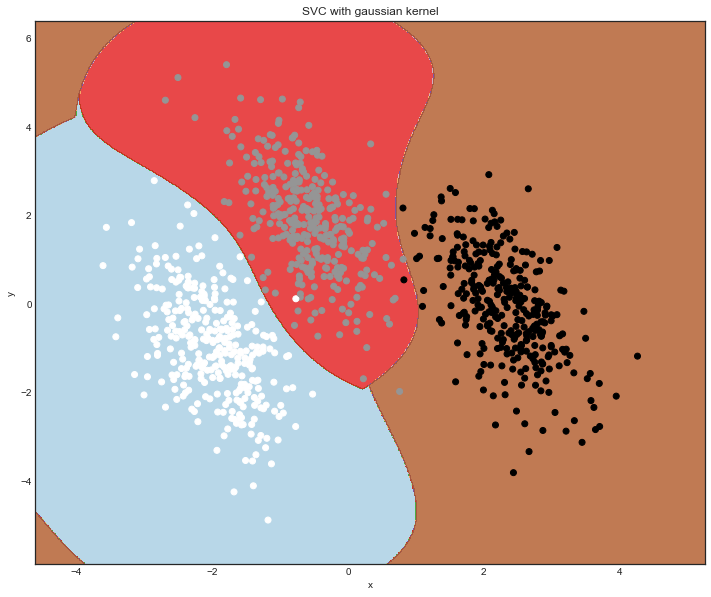

In [25]:
param_grid = {
    'C': np.linspace(0.001, 10,num=30), #30 different C's between 0.01 and 10
    'kernel':['rbf'], 
    'gamma': np.arange(0.001,1,0.05),
}
svc_r = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv = 5, n_jobs = -1)

svc_r.fit(X_train, y_train)
               
print("Best parameters: "+str(svc_r.best_params_))
               
y_predicted = svc_r.predict(X_test)
y_true = y_test

print(classification_report(y_true, y_predicted, zero_division=0))

# create a mesh to plot in
x_min, x_max = df.x.min() - 1, df.x.max() + 1
y_min, y_max = df.y.min() - 1, df.y.max() + 1
h = abs((x_max / x_min)/100)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = svc_r.predict(np.c_[xx.ravel(), yy.ravel()])

#Decision boundary plot
fig = plt.figure(figsize = (12,10))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

#Scatter
plt.scatter(df.x, df.y, c=df.Class)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with gaussian kernel')
plt.show()



## Polynomial kernel

The script would not finish whenever I tried to tune the degree parameter of the poly kernel. Therefore I the default degree of 3 is used.

Best parameters: {'C': 0.552655172413793, 'gamma': 0.901, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       230
           1       0.99      0.99      0.99       224
           2       0.99      1.00      0.99       216

    accuracy                           0.99       670
   macro avg       0.99      0.99      0.99       670
weighted avg       0.99      0.99      0.99       670



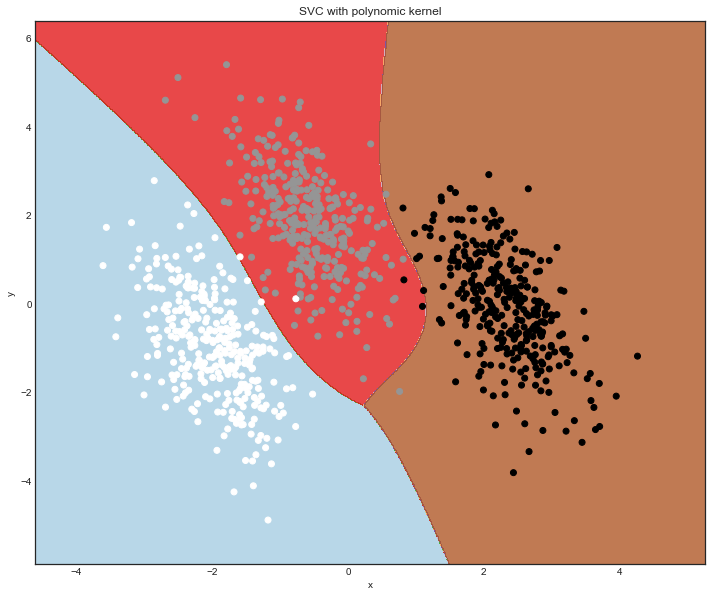

In [26]:
param_grid = {
    'C': np.linspace(0.001, 8,num=30), #30 different C's between 0.01 and 10
    'kernel':['poly'], 
    'gamma': np.arange(0.001,1,0.05),
}
svc_poly = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv = 5, n_jobs = -1)
svc_poly.fit(X_train, y_train)
               
print("Best parameters: "+str(svc_poly.best_params_))
               
y_predicted = svc_poly.predict(X_test)
y_true = y_test

print(classification_report(y_true, y_predicted, zero_division=0))

# create a mesh to plot in
x_min, x_max = df.x.min() - 1, df.x.max() + 1
y_min, y_max = df.y.min() - 1, df.y.max() + 1
h = abs((x_max / x_min)/100)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = svc_poly.predict(np.c_[xx.ravel(), yy.ravel()])


#Decision boundary plot
fig = plt.figure(figsize = (12,10))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

#Scatter
plt.scatter(df.x, df.y, c=df.Class)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with polynomic kernel')
plt.show()


We can see from the plots that all the kernels in priniple get the same classification scoring, with the polynomial kernel being a little worse as it missclassifies a few observations more.

In this exercise I was choosing the margin of the classifiers automatically by evaluating score using gridsearch (the C-parameter). I did not feel the need to experiment with plots for different margins as that will just change how many observations are allowed to be on the wrong side of the boundary. If you choose a too small margin the variance of the model will be very high (overfitting). On the other hand if you choose a too large margin you will have high bias (underfitting). Therefore it is good to use such a method as exhaustive or randomized search and test many different values to find which works the best.

Gamma (not for the linear kernel) is also a hyperparameter which controls the variance/bias tradeoff, and is usually also best found by gridsearch.